### necessary modules

In [17]:
import numpy as np; 
import matplotlib.pyplot as plt; 
from scipy.stats import wilcoxon, f_oneway; 

# nwb related
from pynwb import NWBHDF5IO                        # to read/write
from pynwb import NWBFile                          # to set up
from pynwb.ecephys import LFP, ElectricalSeries    # to add raw data
from pynwb.file import Subject

# datetime related
from datetime import datetime
from dateutil import tz

# to load pre-processed files
import pandas as pd
import json;
import gzip;

from scipy import stats

### To compute spike density function

In [2]:
def getSDF(spkTrain,FS,AllorMean=0):
    # Make gaussian kernel window
    sigma = 5;
    t = np.arange(-3*sigma,3*sigma+1);

    y = (1/sigma*np.sqrt(np.pi*2)) * np.exp(-(t**2)/(2*sigma**2));
    window = y[:];
    window = window/np.sum(window);

    # convolution
    sdf = np.zeros(np.shape(spkTrain));
    for i in np.arange(np.shape(spkTrain)[0]):
        convspike = np.convolve(spkTrain[i,:],window);
        pStart = int(np.floor(len(window)/2));
        pEnd = int(np.floor(len(window)/2)+np.shape(spkTrain)[1]);
        convspike = convspike[pStart:pEnd];
        sdf[i,:] = convspike;
    sdf = sdf*FS;

    if AllorMean==0:
        sdf = np.mean(sdf,axis=0);
    
    return sdf;        

### To access rawdata

In [3]:
def get_metaDict(metaname):
    metaDict = {}
    with open(metaname) as f:
        mdatList = f.read().splitlines()
        # convert the list entries into key value pairs
        for m in mdatList:
            csList = m.split(sep='=')
            if csList[0][0] == '~':
                currKey = csList[0][1:len(csList[0])]
            else:
                currKey = csList[0]
            metaDict.update({currKey: csList[1]})
    return metaDict;


def get_markervals_str(dat_filename):
    fid = open(dat_filename, 'r'); 
    markervals_str = []; 
    while True:
        tline = fid.readline(); 
        if tline=='':
            break; 
        # remove brackets, single quote. then make a single array
        markervals_str += tline[1:-2].replace("'",'').split(', '); 
    return markervals_str; 

def get_nidqData(nidq_name):
    nidq_filename = nidq_name + '.bin'; 
    meta_filename = nidq_name + '.meta'; 

    meta = get_metaDict(meta_filename); 
    nChan = int(meta['nSavedChans'])
    nFileSamp = int(int(meta['fileSizeBytes'])/(2*nChan))
    nidqData = np.memmap(nidq_filename, dtype='int16', mode='r',
                        shape=(nChan, nFileSamp), offset=0, order='F'); 

    niSampRate = 25000
    syncCh = int(meta['syncNiChan']); 
    nidq_syncONs = np.where(nidqData[syncCh,:niSampRate*20]
                        >np.max(nidqData[syncCh,:niSampRate*20])*0.5)[0];    
    for p in range(10):
        if nidq_syncONs[p+10]-nidq_syncONs[p]==10:
            nidq_syncON = nidq_syncONs[p]; 
            break; 

    nidq_time = (np.arange(nFileSamp)-nidq_syncON)/niSampRate; 

    digitCh = np.shape(nidqData)[0]-1;   # the last channel     
    digit_signal = nidqData[digitCh, :]; 
    digit_diff = digit_signal[1:] - digit_signal[:-1]; 

    ### time (ms) with respect to syncON
    markerts = (np.where(digit_diff==2)[0] + 1 - nidq_syncON)/niSampRate; 
    pdOnTS_raw = (np.where(digit_diff==1)[0] + 1 - nidq_syncON)/niSampRate; 
    pdOffTS_raw = (np.where(digit_diff==-1)[0] + 1 - nidq_syncON)/niSampRate; 

    ### this is for photodiode generating pdOn for every frame
    pdOn_dist = pdOnTS_raw[1:] - pdOnTS_raw[:-1];
    pdOnTS = np.append(pdOnTS_raw[0],
                        pdOnTS_raw[np.where(pdOn_dist>0.02)[0]+1]);

    pdOff_dist = pdOffTS_raw[1:] - pdOffTS_raw[:-1];
    pdOffTS = np.append(pdOffTS_raw[np.where(pdOff_dist>0.02)[0]],
                        pdOffTS_raw[-1]); 

    return nidqData, pdOnTS, nidq_time; 


### pre-processed files

In [4]:
files = [
    "/Volumes/TK_exHDD1/NPX/V4_Kiani_Gaze/x230630_combined/processed/x230630_KianiGaze_g1_t1.json.gz",
    "/Volumes/TK_exHDD1/NPX/V4_Kiani_Gaze/x230703_combined/processed/x230703_KianiObject_g1_t1.json.gz",
    "/Volumes/TK_exHDD1/NPX/V4_Kiani_Gaze/x230711_combined/processed/x230711_KianiObject_g0_t0.json.gz"
]

dat_files = [
    "/Volumes/TK_exHDD1/NPX/V4_Kiani_Gaze/x230630_combined/x230630_KianiGaze_g1/x_230630_125235_KianiObject_gaze.dat",
    "/Volumes/TK_exHDD1/NPX/V4_Kiani_Gaze/x230703_combined/x230703_KianiObject_g1/x_230703_105454_KianiObject_gaze.dat",
    "/Volumes/TK_exHDD1/NPX/V4_Kiani_Gaze/x230711_combined/x230711_KianiObject_g0/x_230711_104246_KianiObject_gaze.dat"
]

nidq_files = [
    "/Volumes/TK_exHDD1/NPX/V4_Kiani_Gaze/x230630_combined/x230630_KianiGaze_g1/x230630_KianiGaze_g1_t1.nidq",
    "/Volumes/TK_exHDD1/NPX/V4_Kiani_Gaze/x230703_combined/x230703_KianiObject_g1/x230703_KianiObject_g1_t1.nidq",
    "/Volumes/TK_exHDD1/NPX/V4_Kiani_Gaze/x230711_combined/x230711_KianiObject_g0/x230711_KianiObject_g0_t0.nidq"
]

### Set up a NWB file

In [5]:
nwb_filename = '/Volumes/TK_exHDD1/NPX/V4_Kiani_Gaze/' + 'KianiGaze_DB.nwb'

# General info
nwbfile = NWBFile(
    session_description="combined data from KianiGaze V4 experiment. Jun-Jul 2023",  # required
    identifier='KianiGaze_V4_Jun-Jul2023',  # required
    session_start_time=datetime(2023, 6, 29, 10, 30, 0, tzinfo=tz.gettz('US/Pacific')),  # required
    experimenter="Kim, Taekjun",  # optional
    lab="Pasupathy Laboratory",  # optional
    institution="University of Washington",  # optional
    experiment_description="V4 responses to Kiani Object at 4 different gaze position",  # optional
    session_id="KianiGaze_V4_Jun-Jul2023",  # optional
)

# Subject info
nwbfile.subject = Subject(
    subject_id='Chip',
    age='P1Y/P15Y', 
    description='Monkey Chip',
    species='Macaque Mulatta', 
    sex='M'
)

# Electrode info
device = nwbfile.create_device(
    name='Neuropixels', 
    description="bank0_384ch", 
    manufacturer="IMEC"
)
nwbfile.add_electrode_column(name="label", description="label of electrode")

nprobes = 1
locations = ['V4']; 
nchannels_per_probe = 384

electrode_counter = 0
for iprobe in range(nprobes):

    electrode_group = nwbfile.create_electrode_group(
        name = "probe{}".format(iprobe),
        description = "electrode group for probe {}".format(iprobe),
        device = device,
        location = locations[iprobe],
    )

    for ielec in range(nchannels_per_probe):
        nwbfile.add_electrode(
            group = electrode_group,
            label = "probe{}elec{}".format(iprobe, ielec),
            location = locations[iprobe],
        )
        electrode_counter += 1

# Trial info
nwbfile.add_trial_column(
    name="session", description="session ID")
nwbfile.add_trial_column(
    name="eyeON", description="fixation acquired time")
nwbfile.add_trial_column(
    name="pdON", description="pdON time", index=True)
nwbfile.add_trial_column(
    name="stimCond", description="stim Condition", index=True)
#nwbfile.add_trial_column(
#    name="eyeH", description="eyeH", index=True)
#nwbfile.add_trial_column(
#    name="eyeV", description="eyeV", index=True)
#nwbfile.add_trial_column(
#    name="pd_signal", description="pd_signal", index=True)
nwbfile.add_trial_column(
    name="fixPosition", description="fix position")

# Unit info
nwbfile.add_unit_column(name="session", description="session ID")
nwbfile.add_unit_column(name="unitID", description="unitID in session")
nwbfile.add_unit_column(name="is_sua", description="0: mua, 1: sua")
nwbfile.add_unit_column(name="location", description="brain area")
nwbfile.add_unit_column(name="spike_times", description="spike_times", index=True)
nwbfile.add_unit_column(name="meanSDF", description="meanSDF", index=True)

In [6]:
task_index_in_combine = 1; 

# for smoothing eye signal
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size; 

for f in range(len(files)):
    fNow = files[f]; 

    ff = gzip.GzipFile(fNow,'r'); 
    dNow = json.loads(ff.read().decode('utf-8')); 
    ff.close();

    info_data = np.load(fNow[:54]+'info/imec_datainfo.npy', allow_pickle=True).item();  
    ap_syncON = info_data['ap: firstSamp'][task_index_in_combine] + info_data['ap: syncON'][task_index_in_combine]; 

    markervals_str = get_markervals_str(dat_files[f]); 
    nidqData, pdOnTS, nidq_time = get_nidqData(nidq_files[f]); 

    st = np.load(fNow[:54]+'spike_times.npy'); 
    st = np.array(st).astype(int); 
    sc = np.load(fNow[:54]+'spike_clusters.npy'); 

    KS_label = pd.read_csv(fNow[:54]+'cluster_KSLabel.tsv', sep='\t');
    ids_sua = KS_label[KS_label['KSLabel']=='good']['cluster_id'].values; 

    print(f'session# {f}: raw data ready'); 

    ### ADD TRIAL INFO
    sample_on_str = np.where(np.array(markervals_str) == 'sample_on')[0]; 
    for t in np.arange(len(pdOnTS)):
        if ((markervals_str[sample_on_str[t]-4] == 'end_iti') 
               and (markervals_str[sample_on_str[t]+4] == 'sample_on') 
               and (markervals_str[sample_on_str[t]+8] == 'sample_on')):

            # eyeON
            nidq_rangeA = np.where((nidq_time>=pdOnTS[t]-0.6) & (nidq_time<=pdOnTS[t]))[0];  
            eyeH_abs = np.abs(np.diff(np.convolve(nidqData[0,nidq_rangeA],kernel))); 
            eyeV_abs = np.abs(np.diff(np.convolve(nidqData[1,nidq_rangeA],kernel))); 
            eyeH_abs[:10] = 0; eyeH_abs[-10:] = 0; 
            eyeV_abs[:10] = 0; eyeV_abs[-10:] = 0; 
            """
            try:
                eyeON = nidq_time[nidq_rangeA[np.where((eyeH_abs+eyeV_abs)>15)[0][-1]]]; 
            except:
                eyeON = nidq_time[nidq_rangeA[np.where((eyeH_abs+eyeV_abs)==np.max(eyeH_abs+eyeV_abs))]]; 
            """                
            eyeON = np.max(nidq_time[nidq_rangeA[np.where((eyeH_abs+eyeV_abs)==np.max(eyeH_abs+eyeV_abs))]]);             

            # pdONs
            pdONs = np.array([pdOnTS[t],pdOnTS[t+1],pdOnTS[t+2]]); 

            # stimCond
            stimConds = np.array(
                [int(markervals_str[sample_on_str[t]-1])-200,
                 int(markervals_str[sample_on_str[t]+4-1])-200,
                 int(markervals_str[sample_on_str[t]+8-1])-200]
            ); 

            # eyeH, eyeV, pd_signal
            nidq_rangeB = np.where((nidq_time>=pdOnTS[t]-1) & (nidq_time<=pdOnTS[t]+2))[0];  
            eyeH = np.diff(np.convolve(nidqData[0,nidq_rangeB],kernel)); 
            eyeV = np.diff(np.convolve(nidqData[1,nidq_rangeB],kernel)); 
            pd_signal = nidqData[4,nidq_rangeB]; 

            # fixPosition
            first_stim = int(markervals_str[sample_on_str[t]-1])-200; 
            fixPosition = first_stim//51; 

            nwbfile.add_trial(
                session = f"session_{f}",
                eyeON = eyeON,
                pdON = pdONs, 
                stimCond = stimConds, 
                #eyeH = eyeH[np.arange(0,25000*3,25)],
                #eyeV = eyeV[np.arange(0,25000*3,25)],
                #pd_signal = pd_signal[np.arange(0,25000*3,25)],
                fixPosition = fixPosition,
                start_time = -1.0,
                stop_time = 2.0, 
            )
            del eyeON, pdONs, stimConds, eyeH, eyeV, pd_signal, fixPosition; 
    print(f'session# {f}: trial info was added'); 

    ### ADD UNIT INFO
    neuronIDs = dNow['neuronid']; 
    numNeurons = len(neuronIDs); 
    for c in range(numNeurons):
        unitID = neuronIDs[c]; 

        if unitID in ids_sua:
            is_sua = 1; 
        else:
            is_sua = 0; 

        # st_unit
        st_unit = (st[np.where(sc==unitID)[0]] - ap_syncON)/30000.0;         

        # meanSDF
        meanSDF = np.empty((0,500)); 
        for j in range(204):
            meanSDF = np.vstack((meanSDF,np.array(dNow['StimResp'][j]['neurons'][c]['meanSDF'])[200:700].reshape((1,500)))); 

        nwbfile.add_unit(
            session = f"session_{f}",        
            unitID = int(unitID),
            is_sua = int(is_sua), 
            location = 'V4',  
            spike_times = st_unit.flatten(),
            meanSDF = meanSDF,
        )
        del unitID, is_sua, st_unit, meanSDF; 
    print(f'session# {f}: unit info was added'); 

    del info_data, ap_syncON, markervals_str, nidqData, pdOnTS, nidq_time; 
    del KS_label, st, sc, ids_sua, neuronIDs, numNeurons, dNow; 



session# 0: raw data ready
session# 0: trial info was added
session# 0: unit info was added
session# 1: raw data ready
session# 1: trial info was added
session# 1: unit info was added
session# 2: raw data ready
session# 2: trial info was added
session# 2: unit info was added


### Write file

In [7]:
with NWBHDF5IO(nwb_filename, 'w') as io:
    io.write(nwbfile)

### Read file

In [8]:
nwb_filename = '/Volumes/TK_exHDD1/NPX/V4_Kiani_Gaze/' + 'KianiGaze_DB.nwb'; 
with NWBHDF5IO(nwb_filename, 'r') as io:
    nwbfile = io.read(); 
    units = nwbfile.units.to_dataframe(); 
    trials = nwbfile.trials.to_dataframe(); 

In [34]:
pos_effect_pval = []; 
strength = []; 
for i in range(len(units)):
    psth = units.loc[i,'meanSDF']; 
    mResp = np.mean(psth[:,100:400],axis=1); 
    pos1_resp = mResp[:51]; 
    pos2_resp = mResp[51:102]; 
    pos3_resp = mResp[102:153]; 
    pos4_resp = mResp[153:]; 

    f,pval = f_oneway(pos1_resp,pos2_resp,pos3_resp,pos4_resp);     
    pos_effect_pval.append(pval); 
    strength.append(np.mean(mResp)); 
    del psth, mResp, pos1_resp, pos2_resp, pos3_resp, pos4_resp; 

units['pos_effect_pval'] = pos_effect_pval;  
units['strength'] = strength;  


/Users/taekjunkim/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:3650: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


In [148]:
units[(units['session']=='session_1') & (units['pos_effect_pval']<0.0001) & (units['strength']>1)].sort_values(by='strength',ascending=False)

,session,unitID,is_sua,location,spike_times,meanSDF,pos_effect_pval,strength
id,,,,,,,,
1047,session_1,991,1,V4,"[-311.79356666666666, -310.3842666666667, -309...","[[8.081058640433579, 9.67478371673261, 11.1286...",9.966980e-56,13.966835
1156,session_1,201,0,V4,"[-312.81696666666664, -312.7330333333333, -312...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",6.201691e-28,8.190720
1495,session_1,987,0,V4,"[2062.0416333333333, 2062.413233333333, 2062.4...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1480097...",1.183714e-41,8.002290
1082,session_1,38,0,V4,"[-312.76366666666667, -312.7466, -312.65546666...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4.894470e-05,7.110896
1513,session_1,1057,0,V4,"[-286.6659, -161.6585, -144.8817, -137.7340333...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",7.102372e-22,3.290091
1101,session_1,76,0,V4,"[-312.38143333333335, -311.9002, -310.1633, -3...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",6.300480e-09,3.278338
1054,session_1,1062,1,V4,"[-312.7592333333333, -311.6170333333333, -311....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",6.173020e-24,2.767822
1510,session_1,1046,0,V4,"[-312.73816666666664, -312.7248333333333, -312...","[[0.0, 0.0, 0.0, 0.0, 0.1480097518968666, 0.26...",7.524566e-07,2.210281
1151,session_1,191,0,V4,"[-312.1372, -312.12806666666665, -312.0138, -3...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9.061343e-05,1.749267


### Draw example neuron

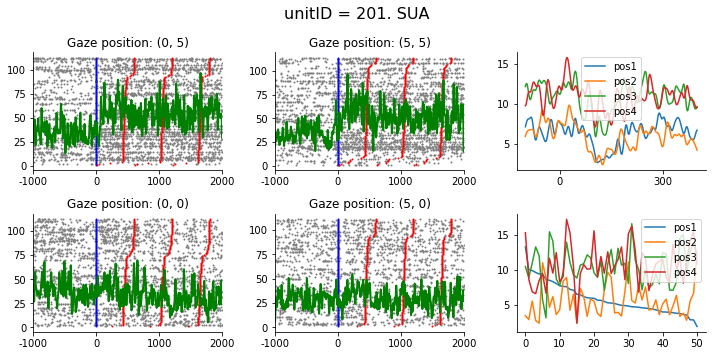

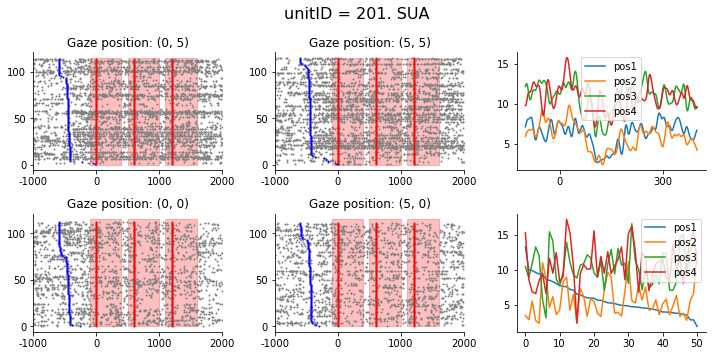

In [156]:
session_num = 1; 
unitID = 201;  #1: 991, 377, 1062, 399, 396, 982, 201

# aligned at FixON
pos1_spkA = np.empty((0,3*1000)); 
pos2_spkA = np.empty((0,3*1000)); 
pos3_spkA = np.empty((0,3*1000)); 
pos4_spkA = np.empty((0,3*1000)); 
# aligned at StimON
pos1_spkB = np.empty((0,3*1000)); 
pos2_spkB = np.empty((0,3*1000)); 
pos3_spkB = np.empty((0,3*1000)); 
pos4_spkB = np.empty((0,3*1000)); 

df = trials[trials['session']==f'session_{session_num}'].reset_index(drop=True); 
df['Eye_to_PD'] = df['pdON'] - df['eyeON']; 
df['Eye_to_PD'] = df['Eye_to_PD'].map(lambda x:x[0])
#df = df[df['Eye_to_PD']>0.3].reset_index(drop=True); 
df = df.sort_values(by='Eye_to_PD').reset_index(drop=True); 
st_unit = units[(units['session']==f'session_{session_num}') & (units['unitID']==unitID)]['spike_times'].values[0]; 

psth = units[(units['session']==f'session_{session_num}') & (units['unitID']==unitID)]['meanSDF'].values[0]
pos1_psth = psth[:51,:]; 
pos2_psth = psth[51:102,:]; 
pos3_psth = psth[102:153,:]; 
pos4_psth = psth[153:,:]; 

mResp = np.mean(psth[:,100:400],axis=1); 
pos1_resp = mResp[:51]; 
pos2_resp = mResp[51:102]; 
pos3_resp = mResp[102:153]; 
pos4_resp = mResp[153:]; 
stim_rank = pos1_resp.argsort()[::-1];      


### Eye align
plt.figure(figsize=(10,5)); 
plt.gcf().suptitle(f"unitID = {unitID}. SUA", fontsize=16)
ax1 = plt.subplot(2,3,1); 
ax2 = plt.subplot(2,3,2); 
ax3 = plt.subplot(2,3,3); 
ax4 = plt.subplot(2,3,4); 
ax5 = plt.subplot(2,3,5); 
ax6 = plt.subplot(2,3,6); 


for i in range(len(df)):

    t1 = df.loc[i,'eyeON']-1; 
    t2 = df.loc[i,'eyeON']+2; 

    stNow = (st_unit[np.where((st_unit>=t1) & (st_unit<=t2))[0]]-t1)*1000; 
    stNow = np.array(stNow).astype(int).flatten(); 
    stNow = stNow[np.where(stNow<3000)[0]]; 
    spkNow = np.zeros((1,3000)); 
    spkNow[0,stNow] = 1; 
    if df.loc[i,'fixPosition']==0:
        pos1_spkA = np.vstack((pos1_spkA,spkNow)); 
        ax4.plot(stNow, np.ones(np.shape(stNow))*np.shape(pos1_spkA)[0],'.',color=(0.5,0.5,0.5),ms=2); 
        ax4.plot(1000,np.shape(pos1_spkA)[0],'b.',ms=2); 
        ax4.plot(1000+df.loc[i,'Eye_to_PD']*1000,np.shape(pos1_spkA)[0],'r.',ms=2);         
        ax4.plot(1600+df.loc[i,'Eye_to_PD']*1000,np.shape(pos1_spkA)[0],'r.',ms=2);         
        ax4.plot(2200+df.loc[i,'Eye_to_PD']*1000,np.shape(pos1_spkA)[0],'r.',ms=2);                 
    elif df.loc[i,'fixPosition']==1:
        pos2_spkA = np.vstack((pos2_spkA,spkNow)); 
        ax5.plot(stNow, np.ones(np.shape(stNow))*np.shape(pos2_spkA)[0],'.',color=(0.5,0.5,0.5),ms=2); 
        ax5.plot(1000,np.shape(pos2_spkA)[0],'b.',ms=2);         
        ax5.plot(1000+df.loc[i,'Eye_to_PD']*1000,np.shape(pos2_spkA)[0],'r.',ms=2);         
        ax5.plot(1600+df.loc[i,'Eye_to_PD']*1000,np.shape(pos2_spkA)[0],'r.',ms=2);         
        ax5.plot(2200+df.loc[i,'Eye_to_PD']*1000,np.shape(pos2_spkA)[0],'r.',ms=2);                 
    elif df.loc[i,'fixPosition']==2:
        pos3_spkA = np.vstack((pos3_spkA,spkNow)); 
        ax2.plot(stNow, np.ones(np.shape(stNow))*np.shape(pos3_spkA)[0],'.',color=(0.5,0.5,0.5),ms=2); 
        ax2.plot(1000,np.shape(pos3_spkA)[0],'b.',ms=2);                 
        ax2.plot(1000+df.loc[i,'Eye_to_PD']*1000,np.shape(pos3_spkA)[0],'r.',ms=2);         
        ax2.plot(1600+df.loc[i,'Eye_to_PD']*1000,np.shape(pos3_spkA)[0],'r.',ms=2);         
        ax2.plot(2200+df.loc[i,'Eye_to_PD']*1000,np.shape(pos3_spkA)[0],'r.',ms=2);                 
    elif df.loc[i,'fixPosition']==3:
        pos4_spkA = np.vstack((pos4_spkA,spkNow)); 
        ax1.plot(stNow, np.ones(np.shape(stNow))*np.shape(pos4_spkA)[0],'.',color=(0.5,0.5,0.5),ms=2); 
        ax1.plot(1000,np.shape(pos4_spkA)[0],'b.',ms=2);                      
        ax1.plot(1000+df.loc[i,'Eye_to_PD']*1000,np.shape(pos4_spkA)[0],'r.',ms=2);         
        ax1.plot(1600+df.loc[i,'Eye_to_PD']*1000,np.shape(pos4_spkA)[0],'r.',ms=2);         
        ax1.plot(2200+df.loc[i,'Eye_to_PD']*1000,np.shape(pos4_spkA)[0],'r.',ms=2);    

ax1.plot(getSDF(pos4_spkA,1000)*5,'g',lw=2); 
ax1.set_title('Gaze position: (0, 5)'); 
ax2.plot(getSDF(pos3_spkA,1000)*5,'g',lw=2); 
ax2.set_title('Gaze position: (5, 5)'); 
ax4.plot(getSDF(pos1_spkA,1000)*5,'g',lw=2); 
ax4.set_title('Gaze position: (0, 0)'); 
ax5.plot(getSDF(pos2_spkA,1000)*5,'g',lw=2); 
ax5.set_title('Gaze position: (5, 0)'); 

ax3.plot(np.arange(-100,400),np.mean(pos1_psth[stim_rank,:],axis=0),label='pos1'); 
ax3.plot(np.arange(-100,400),np.mean(pos2_psth[stim_rank,:],axis=0),label='pos2'); 
ax3.plot(np.arange(-100,400),np.mean(pos3_psth[stim_rank,:],axis=0),label='pos3'); 
ax3.plot(np.arange(-100,400),np.mean(pos4_psth[stim_rank,:],axis=0),label='pos4'); 
ax3.legend(); 
ax3.set_xticks([0,300]); 
ax3.spines[['right', 'top']].set_visible(False); 

ax6.plot(pos1_resp[stim_rank],label='pos1'); 
ax6.plot(pos2_resp[stim_rank],label='pos2'); 
ax6.plot(pos3_resp[stim_rank],label='pos3'); 
ax6.plot(pos4_resp[stim_rank],label='pos4'); 
ax6.legend(); 
ax6.spines[['right', 'top']].set_visible(False)

for i in [1,2,4,5]:
    eval(f'ax{i}.set_xticks(np.arange(0,4000,1000),np.arange(-1000,3000,1000))'); 
    #eval(f'ax{i}.set_yticks(np.arange(0,150,50),np.arange(0,30,10))');     
    eval(f'ax{i}.set_xlim([0,3000])'); 
    eval(f"ax{i}.spines[['right', 'top']].set_visible(False)"); 

plt.tight_layout(); 


### Stim align
plt.figure(figsize=(10,5)); 
plt.gcf().suptitle(f"unitID = {unitID}. SUA", fontsize=16)
ax1 = plt.subplot(2,3,1); 
ax2 = plt.subplot(2,3,2); 
ax3 = plt.subplot(2,3,3); 
ax4 = plt.subplot(2,3,4); 
ax5 = plt.subplot(2,3,5); 
ax6 = plt.subplot(2,3,6); 

for i in range(len(df)):

    ### stim align
    t1 = df.loc[i,'pdON'][0]-1; 
    t2 = df.loc[i,'pdON'][0]+2; 
    
    stNow = (st_unit[np.where((st_unit>=t1) & (st_unit<=t2))[0]]-t1)*1000; 
    stNow = np.array(stNow).astype(int).flatten(); 

    spkNow = np.zeros((1,3000)); 
    stNow = stNow[np.where(stNow<3000)[0]]; 
    spkNow[0,stNow] = 1; 
    if df.loc[i,'fixPosition']==0:
        pos1_spkB = np.vstack((pos1_spkB,spkNow)); 
        ax4.plot(stNow, np.ones(np.shape(stNow))*np.shape(pos1_spkB)[0],'.',color=(0.5,0.5,0.5),ms=2); 
        ax4.plot(1000,np.shape(pos1_spkB)[0],'r.',ms=2); 
        ax4.plot(1600,np.shape(pos1_spkB)[0],'r.',ms=2); 
        ax4.plot(2200,np.shape(pos1_spkB)[0],'r.',ms=2);     
        ax4.plot(1000-df.loc[i,'Eye_to_PD']*1000,np.shape(pos1_spkB)[0],'b.',ms=2);     
    elif df.loc[i,'fixPosition']==1:
        pos2_spkB = np.vstack((pos2_spkB,spkNow)); 
        ax5.plot(stNow, np.ones(np.shape(stNow))*np.shape(pos2_spkB)[0],'.',color=(0.5,0.5,0.5),ms=2); 
        ax5.plot(1000,np.shape(pos2_spkB)[0],'r.',ms=2); 
        ax5.plot(1600,np.shape(pos2_spkB)[0],'r.',ms=2); 
        ax5.plot(2200,np.shape(pos2_spkB)[0],'r.',ms=2);                 
        ax5.plot(1000-df.loc[i,'Eye_to_PD']*1000,np.shape(pos2_spkB)[0],'b.',ms=2);     
    elif df.loc[i,'fixPosition']==2:
        pos3_spkB = np.vstack((pos3_spkB,spkNow)); 
        ax2.plot(stNow, np.ones(np.shape(stNow))*np.shape(pos3_spkB)[0],'.',color=(0.5,0.5,0.5),ms=2); 
        ax2.plot(1000,np.shape(pos3_spkB)[0],'r.',ms=2); 
        ax2.plot(1600,np.shape(pos3_spkB)[0],'r.',ms=2); 
        ax2.plot(2200,np.shape(pos3_spkB)[0],'r.',ms=2);                 
        ax2.plot(1000-df.loc[i,'Eye_to_PD']*1000,np.shape(pos3_spkB)[0],'b.',ms=2);     
    elif df.loc[i,'fixPosition']==3:
        pos4_spkB = np.vstack((pos4_spkB,spkNow)); 
        ax1.plot(stNow, np.ones(np.shape(stNow))*np.shape(pos4_spkB)[0],'.',color=(0.5,0.5,0.5),ms=2); 
        ax1.plot(1000,np.shape(pos4_spkB)[0],'r.',ms=2); 
        ax1.plot(1600,np.shape(pos4_spkB)[0],'r.',ms=2); 
        ax1.plot(2200,np.shape(pos4_spkB)[0],'r.',ms=2);                 
        ax1.plot(1000-df.loc[i,'Eye_to_PD']*1000,np.shape(pos4_spkB)[0],'b.',ms=2);     


#ax1.plot(getSDF(pos4_spkB,1000)*5,'g',lw=2); 
ax1.fill_between(np.arange(900,1400),115,color='r',alpha=0.25); 
ax1.fill_between(np.arange(1500,2000),115,color='r',alpha=0.25); 
ax1.fill_between(np.arange(2100,2600),115,color='r',alpha=0.25);             
ax1.set_title('Gaze position: (0, 5)'); 
#ax2.plot(getSDF(pos3_spkB,1000)*5,'g',lw=2); 
ax2.fill_between(np.arange(900,1400),115,color='r',alpha=0.25); 
ax2.fill_between(np.arange(1500,2000),115,color='r',alpha=0.25); 
ax2.fill_between(np.arange(2100,2600),115,color='r',alpha=0.25);             
ax2.set_title('Gaze position: (5, 5)'); 
#ax4.plot(getSDF(pos1_spkB,1000)*5,'g',lw=2); 
ax4.fill_between(np.arange(900,1400),115,color='r',alpha=0.25); 
ax4.fill_between(np.arange(1500,2000),115,color='r',alpha=0.25); 
ax4.fill_between(np.arange(2100,2600),115,color='r',alpha=0.25);             
ax4.set_title('Gaze position: (0, 0)'); 
#ax5.plot(getSDF(pos2_spkB,1000)*5,'g',lw=2); 
ax5.fill_between(np.arange(900,1400),115,color='r',alpha=0.25); 
ax5.fill_between(np.arange(1500,2000),115,color='r',alpha=0.25); 
ax5.fill_between(np.arange(2100,2600),115,color='r',alpha=0.25);             
ax5.set_title('Gaze position: (5, 0)'); 

ax3.plot(np.arange(-100,400),np.mean(pos1_psth[stim_rank,:],axis=0),label='pos1'); 
ax3.plot(np.arange(-100,400),np.mean(pos2_psth[stim_rank,:],axis=0),label='pos2'); 
ax3.plot(np.arange(-100,400),np.mean(pos3_psth[stim_rank,:],axis=0),label='pos3'); 
ax3.plot(np.arange(-100,400),np.mean(pos4_psth[stim_rank,:],axis=0),label='pos4'); 
ax3.legend(); 
ax3.set_xticks([0,300]); 
ax3.spines[['right', 'top']].set_visible(False); 

ax6.plot(pos1_resp[stim_rank],label='pos1'); 
ax6.plot(pos2_resp[stim_rank],label='pos2'); 
ax6.plot(pos3_resp[stim_rank],label='pos3'); 
ax6.plot(pos4_resp[stim_rank],label='pos4'); 
ax6.legend(); 
ax6.spines[['right', 'top']].set_visible(False); 

for i in [1,2,4,5]:
    eval(f'ax{i}.set_xticks(np.arange(0,4000,1000),np.arange(-1000,3000,1000))'); 
    #eval(f'ax{i}.set_yticks(np.arange(0,150,50),np.arange(0,30,10))');     
    eval(f'ax{i}.set_xlim([0,3000])'); 
    eval(f"ax{i}.spines[['right', 'top']].set_visible(False)"); 

plt.tight_layout(); 
#plt.savefig(f"gaze_position_{unitID}.pdf"); 